In [1]:
%load_ext autoreload
%autoreload 2

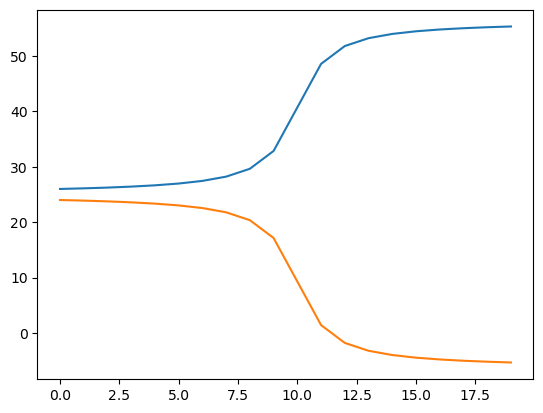

In [12]:
import numpy as np
import matplotlib.pyplot as plt
shape = [20, 2, 50, 50]
img = np.zeros(shape)
p1 = [shape[2]/2, shape[3]/2+10*(np.pi/2+np.arctan(t-shape[0]/2))]
p2 = [shape[2]/2, shape[3]/2-10*(np.pi/2+np.arctan(t-shape[0]/2))]
plt.plot(p1[1])
plt.plot(p2[1])

img[p1]

/media/cephfs2/jparham/Joe for Jerome /SegA Live imaging /20240229_delSegA/CroppedDivisions/01a_delSegA_CM_SyS_reg_Cell_1.tif


Text(0.5, 1.0, '01a_delSegA_CM_SyS_reg_Cell_1')

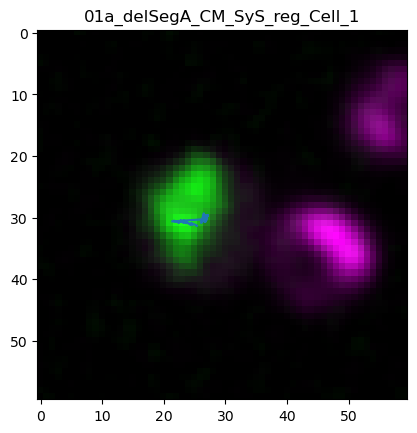

In [28]:
from pathlib import Path
import tifffile
import dnasufo as mq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# list files from the src folder
root = Path('/media/cephfs2/jparham/')
dst = Path('/media/cephfs2/jeromeb/userdata/Baum_group/jparham/Analysis7/')
filelist = pd.read_csv(dst/'filelist.csv')

# 
index = 10
filename = filelist['path'].iloc[index]
print(filename)
pimg, cell_lbl, cell_trj, cell_flow, dna_lbl, dna_trj, dna_flow = mq.process(filename)
plt.imshow(mq.uv2rgb(pimg[0]))
plt.plot(cell_trj['centroid-1'], cell_trj['centroid-0'])
plt.title(Path(filename).stem)

In [30]:
import napari
v = napari.view_image(pimg,channel_axis=1)
v.add_labels(np.squeeze(cell_lbl))
v.add_labels(np.squeeze(dna_lbl))
v.add_tracks(cell_trj[['label', 'frame','centroid-0','centroid-1']])

<Tracks layer 'Tracks' at 0x788b523f4450>

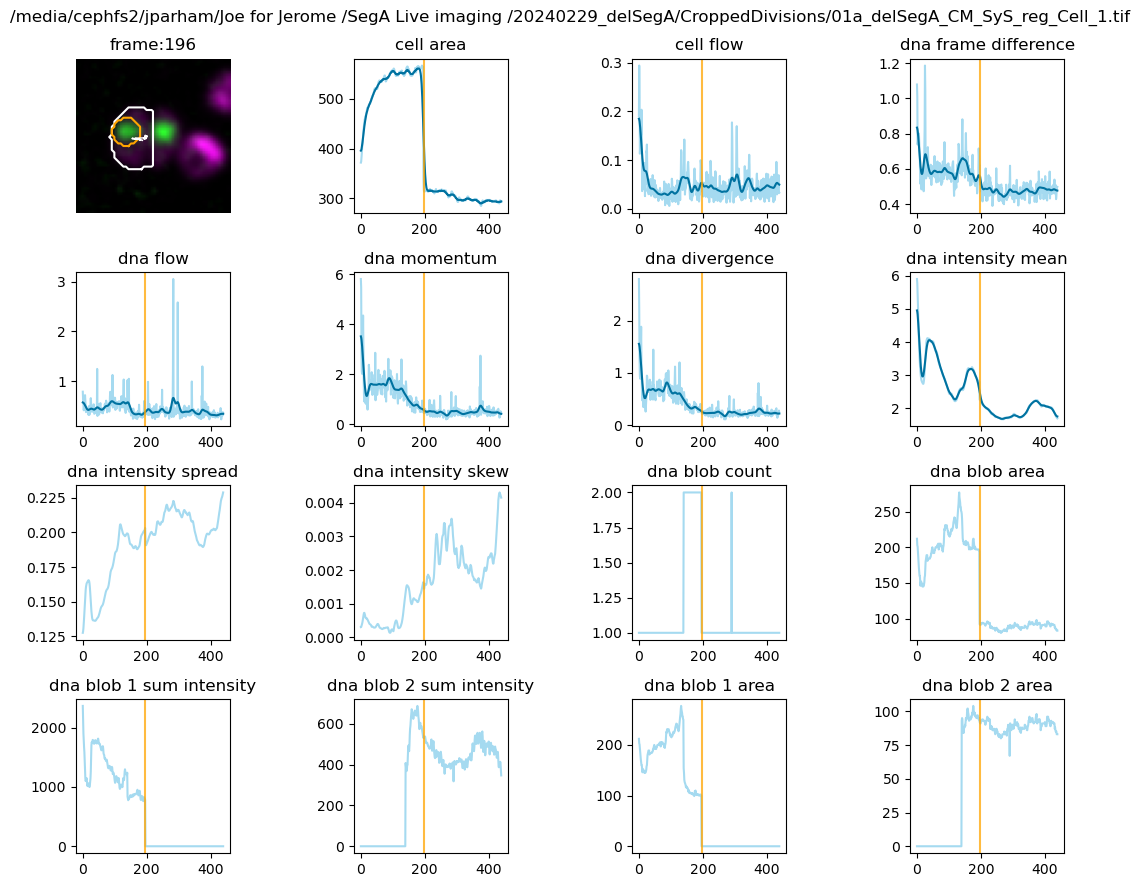

In [31]:
mq.create_figure(index, filename, pimg, cell_lbl, cell_trj, cell_flow, dna_lbl, dna_trj, dna_flow, "auto")

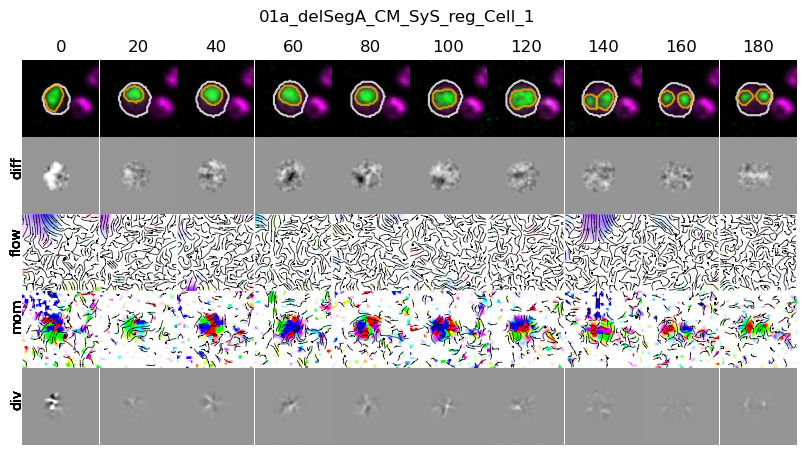

In [36]:
mq.create_strip(filename, pimg, cell_lbl, cell_trj, cell_flow, dna_lbl, dna_trj, dna_flow,selection=slice(0,200,20))

In [40]:
results_path = Path('tmp.h5')
if results_path.exists():
    results_path.unlink()
mq.save_result(results_path, Path(filename).stem, pimg, cell_lbl, cell_trj, cell_flow, dna_lbl, dna_trj, dna_flow)

Motion analysis

In [ ]:
img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blob_trj = mq.load_result("tmp.h5","tmp")

In [ ]:
df = mq.record(filename, img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blob_trj)

In [ ]:
df

In [ ]:
plt.imshow(diff[10,0]*cell_mask[10,0])

In [ ]:
plt.imshow(blob_labels[200]==1)

In [ ]:
plt.plot(df["frame"],df["dna blob 1 sum intensity"])

In [ ]:
blob_trj['particle'].unique()

In [ ]:
count, area, asymmetry_area, intensity, asymmetry_int, tmp = mq.blob_area_num_asymmetry(pimg[:,1], mask)

fig,ax = plt.subplots(5,1)
ax[0].plot(count)
ax[1].plot(area)
ax[2].plot(asymmetry_area)
ax[3].plot(intensity)
ax[4].plot(asymmetry_int)

In [ ]:
t = 100
plt.imshow(mask[t,0]+2*tmp[t] + pimg[t,1])

In [ ]:
import matplotlib.pyplot as plt
from skimage import measure

plt.imshow(mq.uv2rgb(img[300]))
for c in measure.find_contours(mask[0, 0], 0.5):
        plt.plot(c[:, 1], c[:, 0], "w")
plt.plot(position[2:,1], position[2:,0])

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(15,5))
mq.figure(ax,"vv",img, mask, position, speed, diff, flow, rho, div)

In [ ]:
mq.strip(filename.stem, img, mask, position, speed, diff, flow, rho, div, "Greys", step=20, quiver=False)
plt.savefig('tmp.pdf')

In [ ]:
import napari
v = napari.view_image(img,channel_axis=1)
v.add_labels(mask.squeeze())
v.add_points(position,ndim=2)

In [ ]:
import colorsys
print(flow.max())

def vec2rgb(x):
    h = (np.arctan2(x[0],x[1])+3.1415) / (2*3.1415)
    v = np.linalg.norm(x,axis=0)    
    y = np.stack((h,v),-1).reshape(x.shape[1]*x.shape[2],2)         
    return np.stack([colorsys.hsv_to_rgb(hv[0],hv[1],1) for hv in y],0).reshape([x.shape[1],x.shape[2],3])

x,y = np.meshgrid(np.linspace(-1,1),np.linspace(-1,1))
plt.imshow(vec2rgb(np.stack((x,y))))
#plt.imshow(vec2rgb(flow[100]))
